# Computational tools for data science: Comparing Recommendation Systems for MillionSongsDataset

In [1]:
# Imports
import math
import random
import os
import pickle
import pprint
import re
import statistics
import time
from collections import defaultdict
from io import BytesIO
from zipfile import ZipFile
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from datasketch import MinHash, MinHashLSHForest
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from scipy.sparse import csr_matrix
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import paired_distances
from sklearn.neighbors import NearestNeighbors
from tqdm.notebook import tqdm

from pandas.core.common import flatten

import hdf5_getters as hdf5_getters

## Table of contents

1. [Read data](#data)
2. [Content based recommender](#content)
3. [Random baseline recommender](#random)
4. [Clustering based recommender](#clustering)
5. [Collaborative filtering based recommender](#col_filt)
6. [Collaborative filtering with Locality sensitive hashing based recommender](#col_filt_LSH)
7. [Apriori based recommender](#apriori)
8. [Final comparison](#evaluation)

## Read the data
<a id='data'></a>

Assuming that you have all the data in a folder called ```data```

In [2]:
# Read the songs dataset
with ZipFile('data/songs_cleaned.zip', 'r') as zipfile:
    data = zipfile.read('out.csv')

songs_cleaned = pd.read_csv(BytesIO(data))

In [3]:
# And pre-process the artist_terms feature

def ConvertStringtoList(string):
    s = string.replace('[','')
    s = s.replace(']','')
    s = s.replace('\'','')
    s = s.replace(' ','')
    li = list(s.split(","))
    return li

i = 0
for string in songs_cleaned['artist_terms']:
    list_ = ConvertStringtoList(string)
    songs_cleaned['artist_terms'][i] = list_
    i += 1

In [4]:
songs_cleaned.head()

,artist_id,song_id,artist_terms
0,ARMJAGH1187FB546F3,SOCIWDW12A8C13D406,"[blue-eyedsoul, poprock, blues-rock, beachmusi..."
1,ARXR32B1187FB57099,SOFSOCN12A8C143F5D,"[poppunk, skapunk, breakcore, alternativemetal..."
2,AR10USD1187B99F3F1,SOHKNRJ12A6701D1F8,"[post-hardcore, screamo, emo, hardcore, punkre..."
3,ARC43071187B990240,SOKEJEJ12A8C13E0D0,"[ccm, religiousmusic, losangeles, christianroc..."
4,ARL7K851187B99ACD2,SOMUYGI12AB0188633,"[bachata, merengue, reggaeton, latinpop, spani..."


In [5]:
# Read the user tastes' dataset

with ZipFile('data/users_cleaned.zip', 'r') as zipfile:
    data = zipfile.read('out.csv')

users_cleaned = pd.read_csv(BytesIO(data))
print(len(users_cleaned))
users_cleaned.head()

697064


,userID,songID,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOWEZSI12A81C21CE6,1
1,4bd88bfb25263a75bbdd467e74018f4ae570e5df,SODCXXY12AB0187452,2
2,b64cdd1a0bd907e5e00b39e345194768e330d652,SOLXDDC12A6701FBFD,1
3,b64cdd1a0bd907e5e00b39e345194768e330d652,SONQBUB12A6D4F8ED0,2
4,5a905f000fc1ff3df7ca807d57edb608863db05d,SOFKTPP12A8C1385CA,1


In [6]:
# How many different users there are
print("We have a total of", len(set(users_cleaned['userID'])), "users.")

# Let's take a subset of users to evaluate the performance of the various recommendation systems
nb_of_users = 5000

users_subset = users_cleaned[users_cleaned['userID'].isin(list(set(users_cleaned['userID']))[:nb_of_users])]
print("In the subset for the evaluation we have a total number of", len(set(users_subset['userID'])), "users.")

We have a total of 386670 users.
In the subset for the evaluation we have a total number of 5000 users.


In [7]:
users_subset.head()

,userID,songID,play_count
204,dde4fa01de271d51a4a5617ae79820cee7d26d96,SOEHWGF12A6D4F8B2B,2
205,dde4fa01de271d51a4a5617ae79820cee7d26d96,SOKTJKI12A8C143254,3
206,dde4fa01de271d51a4a5617ae79820cee7d26d96,SOMTXSB12AF72ACC38,2
863,fd3b4d56e254080967e51c6a0bb83ef0c3d0b4ce,SOHBOGO12A8C13B8F8,1
940,d15ccfe31ab990bab923ff5ee4970b83a735055b,SOHTWLT12A8C13CFE1,1


# Content based recommendation
<a id='content'></a>

### Represent songs as vectors

We use the feature artist_terms and implement one-hot-encoding. With one-hot-encoding, we convert each categorical value into a new categorical column and assign a binary value 1 or 0 to each feature if the term was initially in the terms of a song.

In [8]:
df_songs = songs_cleaned

In [9]:
# First, extract the set of artist_terms

all_terms = []
for row in range(len(df_songs)):
    if df_songs['artist_terms'][row] == []:
        print('vacia')
    all_terms.append(df_songs['artist_terms'][row])

all_terms = np.concatenate(all_terms)
all_terms = list(set(all_terms)) # we have gotten a list of the set of all artist_terms

d = len(all_terms) # dimension of the vectors we are representing
print('Songs will be represented as binary vectors of dimension', d)

Songs will be represented as binary vectors of dimension 2294


In [10]:
# Now, we intend to create a binary vector (length = d) that represents a song, 
# with 1s if the song has this term and 0s if it hasn't.

def vectorize(song):

    index = int(df_songs.index[df_songs['song_id'] == song][0])
    vector = np.zeros(len(all_terms))

    for i in range(len(vector)):
        if all_terms[i] in df_songs['artist_terms'][index]:
            vector[i] = 1
            
    return vector

In [11]:
# Vectorize ALL the songs and save it into a dictionary

vector_representation = {}

for song in tqdm(df_songs['song_id']):
    vector_representation[song] = vectorize(song)
    
#vector_representation # we end up with a dictionary of songs with their vector representation

  0%|          | 0/3195 [00:00<?, ?it/s]

### Get the user profiles

We will represent each user as a vector of dimension d. 
The representation is the weighted average of the songs that the user has already listened to.

In [12]:
# Compute all the results only for the subset of 5000 users
user_plays = users_subset

In [13]:
# Get the User profile: that will be a vector of dimension d computed as the weighted average of his played songs
# Get user profile for all users

def getUserProfile(user):

    song_counts = list(user_plays[user_plays['userID'] == user]['play_count'])
    song_list = list(user_plays[user_plays['userID'] == user]['songID'])


    # Check if the user songs are in the song dataset and get the indices of the songs
    indices = []
    for song in song_list:
        if song in list(df_songs['song_id']):
            indices.append(song_list.index(song))
        else:
            continue


    # Get the User profile (i.e. Compute the (weighted) average of the songs of a user)
    a = [song_counts[i] for i in indices]
    b = [vector_representation[song_list[i]] for i in indices]

    numerator = np.zeros(d)
    for i in range(len(a)):
        numerator = numerator + ( a[i] * np.asarray(b[i]) )

    user_profile = numerator / sum(a)
    return user_profile

In [14]:
# Get user profiles for every user in the users_plays dataset
# If users_plays = users_cleaned --> Very slow cell (it lasts 1 day). Set to True to run this cell. Or, read the already created dictionary in the file user_profiles.pkl
# Otherwise if users_plays = users_subset, (since it is a subset) OK.

create_user_profiles = True

if create_user_profiles:
    users = set(list(user_plays['userID']))
    user_profiles = {}
    for user in tqdm(users):
        user_profiles[user] = getUserProfile(user)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [15]:
# Save dictionary of user_profiles
# Set to True if you want to save the user_profiles dictionary as a separate file
if create_user_profiles:
    with open("user_profiles.pkl", "wb") as f:
        pickle.dump(user_profiles, f)

In [16]:
# Read user_profiles file and save it into a dictionary
if not create_user_profiles:
    with open("user_profiles.pkl", "rb") as a_file:
        user_profiles = pickle.load(a_file)
print("We have", len(user_profiles), "users in this dictionary.")

We have 5000 users in this dictionary.


### Get recommendation

We will recommend the songs of our dataset that are more similar to the user profile.

In [17]:
# Recommendations for all users

def getRecommendation(user):
    user_profile = user_profiles[user]
    
    scores_dict = {}
    for song in df_songs['song_id']:
        dist = np.linalg.norm(user_profile - vector_representation[song]) # euclidean distance
        scores_dict[song] = dist

    # R best recommendations
    R = 10
    recommended_songs = []
    for score in np.sort(list(scores_dict.values()))[0:R]:
        recommended_songs.append(list({i for i in scores_dict if scores_dict[i]==score}))

    recommended_songs = list(set(np.concatenate(recommended_songs)))

    return recommended_songs

In [18]:
# Create dictionary of user_recommendations
# Set to True if you want to create it again.
# If users_plays = users_cleaned --> Very slow cell (it takes forever)
# Otherwise if users_plays = users_subset, OK.
if True:
    user_recommendations = {}
    counter = 0
    for key in tqdm(user_profiles.keys()):
        if counter < 10000: # control parameter, if we have more than a certain nb of users, don't compute it all
            user_recommendations[key] = getRecommendation(key)
            counter += 1
        else:
            break

  0%|          | 0/5000 [00:00<?, ?it/s]

In [19]:
# Save dictionary of user_recommendations
# Set to True if you want to save the user_recommendations dictionary as a separate file
save_user_recommendations = True
if save_user_recommendations:
    with open("user_recommendations.pkl", "wb") as f:
        pickle.dump(user_recommendations, f)

In [20]:
# Read user_recommendations file and save it into a dictionary
if not save_user_recommendations:
    with open("user_recommendations.pkl", "rb") as a_file:
        user_recommendations = pickle.load(a_file)
    print("We have", len(user_recommendations), "users with their recommendations.")

### Evaluation of recommendation

We can use different methods:

#### Intra-list similarity

Intra-list similarity is the average cosine similarity of all items in a list of recommendations.
Intra-list similarity can be calculated for each user, and averaged over all users in the test set to get an estimate of intra-list similarity for the model.

In [21]:
# Cosine similarity
from numpy.linalg import norm
def cosine_similarity(song1, song2):
    a = vector_representation[song1]
    b = vector_representation[song2]
    dist = np.dot(a,b)/(norm(a)*norm(b))
    return dist

# Intra list similarity function
def intra_list_similarity(user):
    rec = user_recommendations[user]
    
    # All possible pairs in list
    if rec == None:
        return np.NaN
    pairs = [(a, b) for idx, a in enumerate(rec) for b in rec[idx + 1:]]
    
    # Compute the average distances between the pairs of the recommended songs
    distances = []
    for pair in pairs:
        distances.append(cosine_similarity(pair[0], pair[1]))
    
    return np.mean(distances)

In [22]:
# Get the intra-list similarity of the model
# Average of all intra list similarities

intra_list_similar = []
for user in user_recommendations.keys():
    intra_list_similar.append(intra_list_similarity(user))

intra_similar_content = np.mean(intra_list_similar)
print("The intra list similarity for Content based model is:", intra_similar_content)

The intra list similarity for Content based model is: 0.5169866937716748


#### Personalization (in progress)

https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093

#### Evaluation based on similarity of recommended songs to the user profile

This method for evaluation consists of calculating the euclidean distance of the songs recommended to a user and the user profile. Then, we average these distances.

If we compute this measure for every user, we then get the score for our recommendations model.

In [23]:
# Compute the average of the distances of the recommended songs to the user profile 
# Distance can be calculated by euclidean or cosine similarity

def average_distance(user):
    rec = user_recommendations[user]
    user_profile = user_profiles[user]
    if rec == None:
        return np.NaN
    distances = []
    for song in rec:
        a = vector_representation[song]
        distances.append(np.linalg.norm(a-user_profile)) # euclidean distance
    return np.mean(distances)

In [24]:
# Get the average similarity of the model
# Average of all similarities

average_similar = []
for user in user_recommendations.keys():
    average_similar.append(average_distance(user))
average_similar_content = np.mean(average_similar)
print("The average similarity for Content based model is:" , average_similar_content)

The average similarity for Content based model is: 3.1304618950972376


# Random recommendation (baseline)
<a id='random'></a>
The random recommendation model assign a list of random songs to every user.

In [132]:
user_recommendations = {}

for user in set(users_subset['userID']):
    user_recommendations[user] = random.sample(list(songs_cleaned['song_id']), k=10)

#### Intra-list similarity

In [133]:
# Get the intra-list similarity of the model
# Average of all intra list similarities

intra_list_similar = []
for user in user_recommendations.keys():
    intra_list_similar.append(intra_list_similarity(user))
intra_similar_baseline = np.mean(intra_list_similar)
print("The intra list similarity for baseline model is:", intra_similar_baseline)

The intra list similarity for baseline model is: 0.17118468077292823


#### Evaluation based on similarity of recommended songs to the user profile

In [134]:
# Get the average similarity of the model
# Average of all similarities

average_similar = []
for user in user_recommendations.keys():
    average_similar.append(average_distance(user))
average_similar_baseline = np.mean(average_similar)
print("The average similarity for baseline model is:" , average_similar_baseline)

The average similarity for baseline model is: 6.224215751508114


# Clustering
<a id='clustering'></a>

Another method that we could apply to get recommendations based on content (in our case features of the songs) can be through clustering.

In this part, we cluster songs by similarity with K-means algorithm. Then, since we have computed the user profile for every user, we compute the distance of each user to the centroid of each cluster in order to obtain the cluster to which each user is "closer" to. Finally, the recommendation will be a random set of songs of obtained the cluster.

In [29]:
# Show the vector representation of each of the songs in a dataframe

songs_list = list(vector_representation.keys())
songs_representation_list = list(vector_representation.values())

index_dict = {}
for index in range(len(songs_list)):
    index_dict[index] = songs_list[index]
    

columns = []
for i in range(d):
    columns.append(str(i))
    
df_vector_representation = pd.DataFrame(songs_representation_list, columns = columns)
df_vector_representation = df_vector_representation.rename(index = index_dict)
df_vector_representation

,0,1,2,3,4,5,6,7,8,9,...,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293
SOCIWDW12A8C13D406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOFSOCN12A8C143F5D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOHKNRJ12A6701D1F8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOKEJEJ12A8C13E0D0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOMUYGI12AB0188633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SOILDRV12A8C13EB77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOBUUYV12A58A7DA27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOUWMIW12AB0184748,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOLXXPY12A67ADABA0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# K-means algorithm
from sklearn.cluster import KMeans

n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42) 
kmeans.fit(df_vector_representation)
labels = kmeans.labels_

In [31]:
# How many songs are in each cluster
clusterCount = np.bincount(labels)
clusterCount

array([ 819, 1591,  785], dtype=int64)

In [32]:
## Now we have every song in a cluster.
# We identify the centroid of each cluster (cluster_centers_) and compare each user_profile with these.
# We then recommend the songs of the cluster of with the user_profile is closer to the centroid.

cluster_centers = kmeans.cluster_centers_
cluster_centers

array([[ 2.71050543e-19,  1.70940171e-02,  2.71050543e-19, ...,
         4.88400488e-03, -3.90312782e-18,  5.42101086e-19],
       [ 6.28535512e-04,  1.00565682e-02,  6.28535512e-04, ...,
         1.23599048e-17,  7.54242615e-03,  1.25707102e-03],
       [ 2.16840434e-19,  1.14649682e-02,  2.16840434e-19, ...,
         8.67361738e-19, -3.03576608e-18,  4.33680869e-19]])

In [33]:
# Own clustering algorithm
class Kmeans:
    '''Kmeans clustring algorithm. 
    Modeled to take the same input and give the same output as the sklearn Kmeans algorithm'''

    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.cluster_centers_ = None
    
    def fit(self, data):
        np.random.seed(0)  
        N = data.shape[0]
        data = np.array(data)
        idxs = np.random.randint(0, N, self.n_clusters)
        centroids = data[idxs]

        ClusterAssignments = np.zeros(N, dtype=int)
        oldClusterAssignments = True
        while not np.all(ClusterAssignments == oldClusterAssignments):
            oldClusterAssignments = np.copy(ClusterAssignments)

            # assignment
            for i in range(len(data)):
                distances = [np.linalg.norm(data[i] - centroid) for centroid in centroids]
                ClusterAssignments[i] = np.argmin(distances)
                
            # update
            for i, centroid in enumerate(centroids):
                if data[ClusterAssignments == i].shape[0] != 0: # ensure no division by zero
                    centroids[i] = np.mean(data[ClusterAssignments == i])

        self.labels_ = ClusterAssignments
        self.cluster_centers_ = centroids

n_clusters = 3
kmeans = KMeans(n_clusters) 
kmeans.fit(df_vector_representation)
labels = kmeans.labels_
clusterCount = np.bincount(labels)
cluster_centers = kmeans.cluster_centers_
clusterCount

array([1621,  746,  828], dtype=int64)

In [34]:
# Compute the distances for each user to each centroid and recommend the songs of the correspondent cluster

user_recom_cluster = {}

for user, user_profile in tqdm(user_profiles.items()):

    distances = []
    for centroid in cluster_centers:
        distances.append(np.linalg.norm(user_profile - centroid))

    recommended_cluster = np.where(distances == min(distances))[0][0]
    # print("For user", user, "we recommend the songs in cluster", recommended_cluster)
    
    # Get R recommendations from the cluster
    R = 10
    indices = np.where(labels == recommended_cluster)
    user_recom_cluster[user] = list(df_vector_representation.iloc[indices].sample(n=R).index)  

  0%|          | 0/5000 [00:00<?, ?it/s]

#### Evaluation

In [35]:
user_recommendations = user_recom_cluster

#### Intra-list similarity

In [36]:
# Get the intra-list similarity of the model
# Average of all intra list similarities

intra_list_similar = []
for user in user_recommendations.keys():
    intra_list_similar.append(intra_list_similarity(user))
intra_similar_cluster = np.mean(intra_list_similar)
print("The intra list similarity for content based cluster model is:", np.mean(intra_similar_cluster))

The intra list similarity for content based cluster model is: 0.19045215911237823


#### Evaluation based on similarity of recommended songs to the user profile

In [37]:
# Get the average similarity of the model
# Average of all similarities

average_similar = []
for user in user_recommendations.keys():
    average_similar.append(average_distance(user))
average_similar_cluster = np.mean(average_similar)
print("The average similarity for content based cluster model is:", average_similar_cluster)

The average similarity for content based cluster model is: 6.084385427018495


# Item based collaborative filtering (Angeliki)
<a id='col_filt'></a>

<sup>Inspired by https://github.com/csaluja/JupyterNotebooks-Medium/blob/master/CF%20Recommendation%20System-Examples.ipynb<sup>

Read-in the data and create the utility matrix

In [38]:
# create the utility matrix
utility_matrix = users_subset.pivot(index='userID', columns='songID', values='play_count')

# Includes 386670 users and 3195 songs
utility_matrix.shape 

(5000, 1207)

In [39]:
# Narrow down to 10k users and replace the NaN with 0s.

df1 = utility_matrix[utility_matrix.index.isin(list(users_subset['userID']))] # the 5000 users subset
df2 = utility_matrix[~utility_matrix.index.isin(list(users_subset['userID']))][:5000] # other 5000 subset
u1 = pd.concat([df1, df2])
np.nan_to_num(u1,copy=False)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
# users and songs to experiment with
user = '06b4caaf4dcc2476b5ac096f08f4356b6ba9a86a'
#user = '00038cf792e9f9a1cb593dea5779f96195aac68c'
#user = '0002b896949cb2899feaed47104406e99eafa983'
song = 'SOAPNML12A8C13B696'
#song = 'SOSHUVD12A6701F8F9'

samplelist = list(set(users_subset['userID']))  # list(users_subset['userID'][:2])

**I am implementing item based collaborative filtering as it outperforms user based and items are simpler than user tastes**

### Recommend 10 songs to a list of users using adjusted cosine correlation

Difference between Pearson's correlation and adjusted cosine correlation:

   - In pearson correlation, the mean which subtracted is about the particular item itself (ratings from all users), mean(Ri)
   - In adjusted cosine correlation, the mean is about the particular user (ratings to all items), mean(Ru)



In [41]:
# This function computes a adjusted cosine correlation matrix from a utility matrix
def get_adj_cosine_M(utility_matrix):
    M = utility_matrix.to_numpy()
    M_u = M.mean(axis=1)
    item_mean_subtracted = M - M_u[:, None]
    similarity_matrix = 1 - squareform(pdist(item_mean_subtracted.T, 'cosine'))
    
    return pd.DataFrame(similarity_matrix, index=utility_matrix.columns, columns=utility_matrix.columns)

In [42]:
adjcos_sim = get_adj_cosine_M(u1)
adjcos_sim.head()

songID,SOAAAQN12AB01856D3,SOAASSD12AB0181AA6,SOABLAF12AB018E1D9,SOABRXK12A8C130A36,SOABTKM12A8AE4721E,SOACUIU12A6D4F715B,SOADCFY12A6310E353,SOADJND12A8C13BAE1,SOAEEXM12A8C13D6E3,SOAEJTI12A8C145051,...,SOZSKYN12A8C13A883,SOZSPRJ12A8C13EC7C,SOZTGIY12A8AE47722,SOZTUDR12A8C13FE3F,SOZVZWP12A58A7BAD1,SOZWAMN12AB018234D,SOZWCKB12AB0186C5B,SOZXTKD12A8C13FC43,SOZZPYH12AB0187578,SOZZQBH12A6D4FAFD8
songID,,,,,,,,,,,,,,,,,,,,,
SOAAAQN12AB01856D3,1.000000,0.043296,-0.014965,-0.003905,0.200643,-0.015117,-0.007919,0.023624,0.202002,0.012878,...,0.082653,0.054994,0.194461,0.100421,0.055489,0.153211,0.193420,0.095180,0.043825,0.073259
SOAASSD12AB0181AA6,0.043296,1.000000,-0.004696,-0.001409,0.057151,-0.004618,-0.002515,0.006543,0.057564,0.003516,...,0.023488,0.015594,0.055268,0.028593,0.015712,0.043655,0.054951,0.027019,0.012444,0.020818
SOABLAF12AB018E1D9,-0.014965,-0.004696,1.000000,-0.003637,-0.019660,-0.002750,-0.002732,-0.004842,-0.019431,-0.003327,...,-0.008842,-0.006336,-0.020707,-0.009977,-0.006698,-0.014806,-0.020884,-0.010566,-0.004820,-0.007837
SOABRXK12A8C130A36,-0.003905,-0.001409,-0.003637,1.000000,-0.005092,-0.002507,-0.002196,-0.002326,-0.004879,-0.001737,...,-0.002605,-0.002043,-0.006064,-0.002642,-0.002270,-0.003747,-0.006228,-0.003263,-0.001472,-0.002309
SOABTKM12A8AE4721E,0.200643,0.057151,-0.019660,-0.005092,1.000000,-0.019887,-0.010398,0.031219,0.266604,0.017029,...,0.109100,0.072597,0.256683,0.132541,0.073256,0.202210,0.255312,0.125641,0.057850,0.096701


In [43]:
# This function finds k similar songs given songID and adjusted cosine matrix
def get_similar_songs_adjcosine(songID, adj_sim_m, k):
    '''Find k similar songs given songID and adjusted cosine matrix '''
    
    # sort the similarities and grab k highest values
    similarities = adj_sim_m[songID].sort_values(ascending=False)[:k].values
    # grab the songIDs
    indices = adj_sim_m[songID].sort_values(ascending=False)[:k].index
    
    # print('{} most similar items for item {}:\n'.format(k,songID))
    for i in range(0, len(indices)):
        #first index is songID by default
        if indices[i] == songID:
            continue;
        # else:
            # print('{}: Song {} , with similarity of {}'.format(i,indices[i], similarities[i]))
        
    return similarities, indices.to_list()

In [44]:
#This function recommends 10 songs based on item-item collaborative filtering
# given a list of users and a utility matrix (database)
def recommend10Items(user_list, database):
    result = dict()
    # compute adjusted cosine similarity matrix
    sim_matrix = get_adj_cosine_M(database)
    
    for userID in tqdm(user_list):
        # find row corresponding to user in database
        idx = database.index.get_loc(userID)
        #get the top 5 songs that he already likes
        likes = database.iloc[idx, np.argsort(-database.values[idx])[:5]].index
        
        for songID in likes:
            similarities, recommendations = get_similar_songs_adjcosine(songID, sim_matrix, 1)
            
            if userID not in result:
                result[userID] = recommendations
            elif type(result[userID]) == list:
                result[userID].append(recommendations)
            else:
                result[userID] = [result[userID], recommendations]
    
    return result

In [45]:
get_recom = recommend10Items(samplelist, u1)

# flatten the recommendation list

for user, rec in get_recom.items():
    get_recom[user] = list(flatten(rec))

user_recommendations = get_recom
# user_recommendations

  0%|          | 0/5000 [00:00<?, ?it/s]

#### Intra-list similarity

Intra-list similarity is the average cosine similarity of all items in a list of recommendations.
Intra-list similarity can be calculated for each user, and averaged over all users in the test set to get an estimate of intra-list similarity for the model.

In [46]:
# Get the intra-list similarity of the model
# Average of all intra list similarities

intra_list_similar = []
for user in user_recommendations.keys():
    intra_list_similar.append(intra_list_similarity(user))
intra_similar_collab = np.mean(intra_list_similar)
print("The intra list similarity for Item based collaborative filtering model is:" ,np.mean(intra_similar_collab))

The intra list similarity for Item based collaborative filtering model is: 0.17295221428930535


#### Evaluation based on similarity of recommended songs to the user profile

In [47]:
# Get the average similarity of the model
# Average of all similarities

average_similar = []
for user in user_recommendations.keys():
    average_similar.append(average_distance(user))
average_similar_collab = np.mean(average_similar)
print("The average similarity for Item based collaborative filtering model is:" , np.mean(average_similar_collab))

The average similarity for Item based collaborative filtering model is: 5.047280105458063


### Recommend 10 songs to a list of users by implementig kNN search for item based filtering

In [48]:
def get_similar_songs_kNN(songID, user_profiles, similarity_metric , k):
    '''Find k most similar songs to a given songID'''
    similarity = list()
    neigh_ind = list()
    song_profiles=user_profiles.T
    
    knn = NearestNeighbors(metric = similarity_metric , algorithm = 'brute')
    knn.fit(song_profiles.values) #taking .values to avoid sklearn warning
                                #UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
    
    neigh_dist, neigh_ind = knn.kneighbors(song_profiles.loc[songID].values.reshape(1,-1), n_neighbors = k+1) #plus one, bcs it includes the user we want to compare against 
    similarity = 1-neigh_dist.flatten()
    
    similar_songs = []
    for i in range(0,len(neigh_ind.flatten())):
        if song_profiles.index[neigh_ind.flatten()[i]] == songID:
            continue;
        else:
            similar_songs.append(song_profiles.index[neigh_ind.flatten()[i]])
            
    return similar_songs

In [49]:
def recommend10Items_kNN(user_list, database):
    result = dict()
    
    for userID in tqdm(user_list):
        # find row corresponding to user in database
        idx = database.index.get_loc(userID)
        #get the top 5 songs that he already likes
        likes = database.iloc[idx, np.argsort(-database.values[idx])[:5]].index
        
        for songID in likes:
            simsongs= get_similar_songs_kNN(songID, database, 'cosine', 1)
            
            if userID not in result:
                result[userID] = simsongs
            elif type(result[userID]) == list:
                result[userID].append(simsongs)
            else:
                result[userID] = [result[userID], simsongs]
    
    return result

In [50]:
get_recom_kNN = recommend10Items_kNN(samplelist, u1)

# flatten the recommendation list
for user, rec in get_recom_kNN.items():
    get_recom_kNN[user] = list(flatten(rec))

user_recommendations = get_recom_kNN

  0%|          | 0/5000 [00:00<?, ?it/s]

#### Intra-list similarity

Intra-list similarity is the average cosine similarity of all items in a list of recommendations.
Intra-list similarity can be calculated for each user, and averaged over all users in the test set to get an estimate of intra-list similarity for the model.

In [51]:
# Get the intra-list similarity of the model
# Average of all intra list similarities

intra_list_similar = []
for user in user_recommendations.keys():
    intra_list_similar.append(intra_list_similarity(user))
intra_similar_collab_knn = np.mean(intra_list_similar)
print("The intra list similarity for Item based collaborative filtering by implementing kNN model is:", intra_similar_collab_knn)

The intra list similarity for Item based collaborative filtering by implementing kNN model is: 0.17604830326617293


#### Evaluation based on similarity of recommended songs to the user profile

In [52]:
# Get the average similarity of the model
# Average of all similarities

average_similar = []
for user in user_recommendations.keys():
    average_similar.append(average_distance(user))
average_similar_collab_knn = np.mean(average_similar)
print("The average similarity for Item based collaborative filtering by implementing kNN model is:", average_similar_collab_knn)

The average similarity for Item based collaborative filtering by implementing kNN model is: 5.972384648012992


# Locality Sensitive hashing in Collaborative item-item filtering (inspired by week5 : SimilarItems)
<a id='col_filt_LSH'></a>

In [53]:
def triplets_to_utility_matrix(frame):
    start_time = time.time()
    # person_u = list(frame.userID.unique())
    # thing_u = list(frame.songID.unique())
    # data = frame['play_count'].tolist()
    # row = frame.userID.astype('category').cat.codes
    # col = frame.songID.astype('category').cat.codes
    # sparse_matrix = csr_matrix((data, (row, col)), shape=(len(person_u), len(thing_u)))
    # user_profiles = pd.DataFrame.sparse.from_spmatrix(sparse_matrix, index=person_u, columns=thing_u)
    user_profiles = frame.pivot(index='userID', columns='songID', values='play_count')

    # Creater smaller dataset
    # split = int(386670/5)
    # u1 = user_profiles[:split]
    # u1 = u1.sparse.to_dense()
    u1 = user_profiles#.sparse.to_dense()
    # Normalize play counts
    u1.replace(0, np.nan, inplace=True)
    u1 = u1.sub(u1.mean(axis=1, skipna=True), axis=0) # substract from each cell the row mean
    # if value >=0 user likes song
    u1[u1 >= 0] = 1
    u1[u1 < 0] = 0
    u1 = u1.T
    # Keep users that have liked more than 4 songs 
    cols = np.where(u1.notna().sum() >= 4)
    sub1 = u1.iloc[:, np.r_[cols]]
    print('It took %s seconds.' %(time.time()-start_time))

    return sub1

In [54]:
m = triplets_to_utility_matrix(users_subset)

It took 0.33899641036987305 seconds.


In [55]:
def create_database(utility_matrix):
    start_time = time.time()
    cols = utility_matrix.columns.to_numpy() # the users 
    vectors_list = [cols[x].tolist() for x in utility_matrix.eq(1).to_numpy()] # each vector is a song, contains users that liked that song
    df_new = pd.DataFrame(vectors_list, index = utility_matrix.index)
    df_new_reduced = df_new.mask(df_new.eq('None')).dropna(how = 'all')
    df_new_reduced['users'] = df_new_reduced[df_new_reduced.columns].apply( lambda x: ','.join(x.dropna().astype(str)),axis=1)
    data = df_new_reduced['users'].copy()
    database = pd.DataFrame(data)
    print('It took %s seconds.' %(time.time()-start_time))

    return database

def get_items_from_user(userID, utility_matrix):
    '''Given a user find the list of items he likes'''
    #list containing the songs the user likes
    songs = utility_matrix.index[utility_matrix[userID].eq(1)].tolist() 

    return songs

def preprocess(text):
    tokens = text.split()
    return tokens
def get_forest(data, perms):
    start_time = time.time()
    
    minhash = []
    
    for users in data['users']:
        tokens = preprocess(users) # list of users
        m = MinHash(num_perm=perms)
        for s in tokens:
            m.update(s.encode('utf8'))
        minhash.append(m)
        
    forest = MinHashLSHForest(num_perm=perms)
    
    for i,m in enumerate(minhash):
        forest.add(i,m)
        
    forest.index()
    print('It took %s seconds to build forest.' %(time.time()-start_time))
    return forest

def predict(song_profile, database, perms, num_results, forest): # song_profile in list form
    
    #song_profiles = get_items_from_user(userID, utility_matrix ,database)
    start_time = time.time()
    
    m = MinHash(num_perm=perms)
    for users in song_profile:
        m.update(users.encode('utf8'))
        
    idx_array = np.array(forest.query(m, num_results*2))
    if len(idx_array) == 0:
        return None # if your query is empty, return none
    
    result = database.iloc[idx_array]['users']

    # print('It took %s seconds to query forest.' %(time.time()-start_time))
    
    return result, idx_array

In [56]:
db = create_database(m)

It took 0.1979982852935791 seconds.


In [57]:
#Number of Permutations
permutations = 256
#Number of recommendations to return
num_recommendations = 10
forest = get_forest(db, permutations)

It took 1.3970820903778076 seconds to build forest.


In [58]:
def get_recommendations(userID, utility_matrix, database, permutations, num_recommendations, forest):
    items = get_items_from_user(userID, utility_matrix)
    for i in range(0,len(items)):
        # for each song user likes get the song's item_profile vector
        item_profile = database.loc[items[i]] #.to_numpy()
        # get recommendetions based on each song user likes
        result, i = predict(item_profile, database, permutations, num_recommendations, forest)
        # print('\n Top Recommendation(s) is(are) \n', result)

In [59]:
users_recommendations = {}
for key in tqdm(m.columns):
    if counter < 10000: # control parameter, if we have more than a certain nb of users, don't compute it all
        user_recommendations[key] = get_recommendations(key, m, db, permutations, num_recommendations, forest)
        counter += 1
    else:
        break

  0%|          | 0/469 [00:00<?, ?it/s]

**Troubleshooting**: This implementation is not producing the expected outcome. Given more time, I would do debugging and further investigation. The LSH method is used extensively for document recommendation (with shingling).
As a **future extension**, I would try to apply this method to lyrics documents that match with our database data. In this way songs would be recommended based on their lyrics compared to lyrics of songs that the user likes.

#### Intra-list similarity

Sometimes this method is unable to provide any recommendations, and therefore the nanmean function is used. So whenever it was not possible to get a recommendation that user is just ignored in the calculation

In [60]:
# Get the intra-list similarity of the model
# Average of all intra list similarities

intra_list_similar = []
for user in user_recommendations.keys():
    intra_list_similar.append(intra_list_similarity(user))
intra_list_similar_LSH = np.nanmean(intra_list_similar)
print("The intra list similarity for LSH model is:", intra_list_similar_LSH)

The intra list similarity for LSH model is: 0.16675927728694256


#### Evaluation based on similarity of recommended songs to the user profile

In [61]:
# Get the average similarity of the model
# Average of all similarities

average_similar = []
for user in user_recommendations.keys():
    average_similar.append(average_distance(user))
average_similar_LSH = np.nanmean(average_similar)
print("The average similarity for LSH model is:", average_similar_LSH)

The average similarity for LSH model is: 6.103317593699699


# Apriori algorithm based recommendation system
<a id='apriori'></a>


https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/#apriori-frequent-itemsets-via-the-apriori-algorithm

https://rasbt.github.io/mlxtend/

Week 6 exercises

In [62]:
#df = pd.DataFrame(data, columns=['artist_id', 'artist_name', 'artist_location', 'song_id', 'song_name', 'song_hottness','time_signature','artist_terms','artist_mbtags','mode','year','latitude','longitude'])
create_dataset = False
if create_dataset:
    path = 'MillionSongSubset'
    songs_list = []

    for (root, dirs, file) in os.walk(path):
        for f in file:
            songs_list.append(os.path.dirname(f))

    songs_file_paths = []

    for root, dirs, files in os.walk(os.path.abspath(path)):
        for file in files:        
            strs = os.path.join(root, file)
            new_strs = strs.replace('\\','/')
            songs_file_paths.append(new_strs)
    ### CREATE PANDAS TABLE

    N = len(songs_file_paths)
    data = []

    for i in range(N):
        record = []
        # Open specific song path
        h5 = hdf5_getters.open_h5_file_read(songs_file_paths[i])
        
        #getters
        artist_id = hdf5_getters.get_artist_id(h5)
        artist_id = artist_id.decode("utf-8")     
        song_id = hdf5_getters.get_song_id(h5)
        song_id = song_id.decode("utf-8")
        
        song_name = hdf5_getters.get_title(h5)
        song_name = song_name.decode("utf-8")
        artist_terms_ = hdf5_getters.get_artist_terms(h5)
        artist_terms = []
        for j in range(len(artist_terms_)):
            artist_terms.append(artist_terms_[j].decode("utf-8"))
        # Close file
        h5.close()
        
        record.append(artist_id)
        record.append(song_id)
        record.append(song_name)
        record.append(artist_terms)
        data.append(record)

with open('data/MillionSongSubset.pkl', 'rb') as f:
    df = pickle.load(f)
df

,artist_id,song_id,song_name,artist_terms
0,ARD7TVE1187B99BFB1,SOMZWCG12A8C13C480,I Didn't Mean To,"[hip hop, underground rap, g funk, alternative..."
1,ARMJAGH1187FB546F3,SOCIWDW12A8C13D406,Soul Deep,"[blue-eyed soul, pop rock, blues-rock, beach m..."
2,ARKRRTF1187B9984DA,SOXVLOJ12AB0189215,Amor De Cabaret,"[salsa, cumbia, tejano, ranchera, latin pop, l..."
3,AR7G5I41187FB4CE6C,SONHOTT12A8C13493C,Something Girls,"[pop rock, new wave, dance rock, rock, new rom..."
4,ARXR32B1187FB57099,SOFSOCN12A8C143F5D,Face the Ashes,"[pop punk, ska punk, breakcore, alternative me..."
...,...,...,...,...
9995,AR4C6V01187FB3BAF4,SOLXXPY12A67ADABA0,The Hanged Man,"[sympho black metal, black metal, heavy metal,..."
9996,AR9JLBU1187B9AAEC4,SOAYONI12A6D4F85C8,The Wonderful World Of The Young,"[ballad, disco, northern soul, chanson, smooth..."
9997,ARS1DCR1187B9A4A56,SOJZLAJ12AB017E8A2,Sentimental Man,"[lovers rock, reggae, roots reggae, dub, orche..."
9998,ARAGMIV11F4C843F78,SORZSCJ12A8C132446,Zydeco In D-Minor,"[zydeco, cajun]"


In [64]:
df1 = df[df.duplicated(['artist_id'], keep=False)]
df1

,artist_id,song_id,song_name,artist_terms
0,ARD7TVE1187B99BFB1,SOMZWCG12A8C13C480,I Didn't Mean To,"[hip hop, underground rap, g funk, alternative..."
1,ARMJAGH1187FB546F3,SOCIWDW12A8C13D406,Soul Deep,"[blue-eyed soul, pop rock, blues-rock, beach m..."
2,ARKRRTF1187B9984DA,SOXVLOJ12AB0189215,Amor De Cabaret,"[salsa, cumbia, tejano, ranchera, latin pop, l..."
3,AR7G5I41187FB4CE6C,SONHOTT12A8C13493C,Something Girls,"[pop rock, new wave, dance rock, rock, new rom..."
4,ARXR32B1187FB57099,SOFSOCN12A8C143F5D,Face the Ashes,"[pop punk, ska punk, breakcore, alternative me..."
...,...,...,...,...
9995,AR4C6V01187FB3BAF4,SOLXXPY12A67ADABA0,The Hanged Man,"[sympho black metal, black metal, heavy metal,..."
9996,AR9JLBU1187B9AAEC4,SOAYONI12A6D4F85C8,The Wonderful World Of The Young,"[ballad, disco, northern soul, chanson, smooth..."
9997,ARS1DCR1187B9A4A56,SOJZLAJ12AB017E8A2,Sentimental Man,"[lovers rock, reggae, roots reggae, dub, orche..."
9998,ARAGMIV11F4C843F78,SORZSCJ12A8C132446,Zydeco In D-Minor,"[zydeco, cajun]"


In [74]:
user_plays = users_subset
users_subset

,userID,songID,play_count
204,dde4fa01de271d51a4a5617ae79820cee7d26d96,SOEHWGF12A6D4F8B2B,2
205,dde4fa01de271d51a4a5617ae79820cee7d26d96,SOKTJKI12A8C143254,3
206,dde4fa01de271d51a4a5617ae79820cee7d26d96,SOMTXSB12AF72ACC38,2
863,fd3b4d56e254080967e51c6a0bb83ef0c3d0b4ce,SOHBOGO12A8C13B8F8,1
940,d15ccfe31ab990bab923ff5ee4970b83a735055b,SOHTWLT12A8C13CFE1,1
...,...,...,...
696493,fa07cb9736225508d7b3513e0939363caacac055,SOAYOFO12AF72A4B88,1
696494,fa07cb9736225508d7b3513e0939363caacac055,SOTXXBT12A6D4F6B25,2
696495,fa07cb9736225508d7b3513e0939363caacac055,SOYSUZL12A6D4F9005,1
696549,e24f81b3b2aa99eb3844c6224a55710455b0a565,SOSELMV12A6D4FCF5A,5


In [70]:
all_user_songs = user_plays['songID']
myset_user = set(all_user_songs)
print(len(myset_user))

1207


In [87]:
songs_set = set(df['song_id'])
z = myset_user.intersection(songs_set)
baskets = df1['artist_terms'].tolist()

In [76]:
te = TransactionEncoder()
te_ary = te.fit(baskets).transform(baskets)
df2 = pd.DataFrame(te_ary, columns=te.columns_)
df2

,00s,00s country,1800s,1970s soul,19th century,19th century classical,19th century opera,2 meter sessies,2 step,2 tone,...,zaire,zairean,zimbabwe,zommetal,zouk,zouklove,zxzw,zxzw 2006,zxzw 2008,zydeco
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8434,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8435,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8436,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8437,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [77]:
apr = apriori(df2, min_support=0.05, use_colnames=True)
apr['length'] = apr['itemsets'].apply(lambda x: len(x))

In [78]:
ml_freq_pairs = []
for i in apr[apr['length']==5].itemsets.values:
    ml_freq_pairs.append(list(i))

print(len(ml_freq_pairs))

436


In [79]:
artist_terms_df = df['artist_terms']

In [80]:
apr['length'] = apr['itemsets'].apply(lambda x: len(x))
apr

,support,itemsets,length
0,0.076549,(00s),1
1,0.093494,(60s),1
2,0.104989,(70s),1
3,0.165778,(80s),1
4,0.134258,(90s),1
...,...,...,...
4313,0.064818,"(rock, pop rock, jazz, electronic, pop, hip hop)",6
4314,0.051546,"(rock, reggae, jazz, electronic, pop, hip hop)",6
4315,0.053442,"(rock, reggae, pop rock, electronic, pop, hip ...",6
4316,0.052376,"(rock, soft rock, pop rock, jazz, electronic, ...",6


In [81]:
ml_freq_pairs = []
for i in apr[apr['length']==5].itemsets.values:
    ml_freq_pairs.append(list(i))

print(len(ml_freq_pairs))

436


In [82]:
artist_terms_df = df['artist_terms']
artist_terms_df

0       [hip hop, underground rap, g funk, alternative...
1       [blue-eyed soul, pop rock, blues-rock, beach m...
2       [salsa, cumbia, tejano, ranchera, latin pop, l...
3       [pop rock, new wave, dance rock, rock, new rom...
4       [pop punk, ska punk, breakcore, alternative me...
                              ...                        
9995    [sympho black metal, black metal, heavy metal,...
9996    [ballad, disco, northern soul, chanson, smooth...
9997    [lovers rock, reggae, roots reggae, dub, orche...
9998                                      [zydeco, cajun]
9999    [christian rock, christian alternative rock, c...
Name: artist_terms, Length: 10000, dtype: object

In [83]:
### GET USERS TASTE
#triples
user_plays = users_subset
# user_plays = pd.read_csv('data/triplets_50000.txt', sep='\t', names = ['userID','songID', 'play_count'])

In [84]:
apr['length'] = apr['itemsets'].apply(lambda x: len(x))
apr

,support,itemsets,length
0,0.076549,(00s),1
1,0.093494,(60s),1
2,0.104989,(70s),1
3,0.165778,(80s),1
4,0.134258,(90s),1
...,...,...,...
4313,0.064818,"(rock, pop rock, jazz, electronic, pop, hip hop)",6
4314,0.051546,"(rock, reggae, jazz, electronic, pop, hip hop)",6
4315,0.053442,"(rock, reggae, pop rock, electronic, pop, hip ...",6
4316,0.052376,"(rock, soft rock, pop rock, jazz, electronic, ...",6


In [88]:
songs_cleaned = df.loc[df['song_id'].isin(z)]

In [89]:
if not os.path.exists('data/users_cleaned.zip'):
    compression_opts = dict(method='zip', archive_name='out.csv')  
    users_cleaned.to_csv('data/users_cleaned.zip', index=False, compression=compression_opts)  
    songs_cleaned.to_csv('data/songs_cleaned.zip', index=False, compression=compression_opts)  

In [90]:
def getUserSongTags(userID):
    one_user_data = users_cleaned.loc[users_cleaned['userID'] == userID]
    songs = one_user_data['songID']
    tag_list = []
    print(one_user_data)
    
    for song in songs:
        song_data = songs_cleaned.loc[songs_cleaned['song_id'] == song]
        tags = song_data['artist_terms']
        tag_list.append(list(tags))
    
    return tag_list
    

In [91]:
def getUserSongTagsMULTIPLIED(userID):
    one_user_data = users_cleaned.loc[users_cleaned['userID'] == userID]
    songs = one_user_data['songID']
    tag_list = []
    
    
    for song in songs:
        song_data = songs_cleaned.loc[songs_cleaned['song_id'] == song]
        a = one_user_data.loc[one_user_data['songID'] == song]
        song_play_count = a['play_count']
        tags = song_data['artist_terms']
        #print(song_play_count)
        ints = int(song_play_count)
        #print('AFTER : ', ints)
        for i in range(0, (ints+1)):
            tag_list.append(list(tags))
            #print(i)
        
        #print(tags)
        #print(song_play_count)
    
    return tag_list
    

In [92]:
user_tags = getUserSongTagsMULTIPLIED('8305c896f42308824da7d4386f4b9ee584281412')


In [93]:
def listToString(s):
   
    # initialize an empty string
    str1 = " "
   
    # return string 
    sj = (str1.join(s))
    return sj

In [94]:
user_tags = getUserSongTagsMULTIPLIED('8305c896f42308824da7d4386f4b9ee584281412')

#print(user_tags)

## TF IDF

In [95]:
def getTFIDFuser(userID):
    user_tags = getUserSongTagsMULTIPLIED(userID)
    #print(user_tags)
    
    tf_dc = {}
    other_documents = []
    # porter = nltk.PorterStemmer()
    tokenizer = RegexpTokenizer(r'\w+')
    doc = []
    
    for i in range(len(user_tags)):
        if len(user_tags[i]) > 0:
            doc.append(listToString(user_tags[i][0]))
        # var = user_tags[i][0]
        # #print(var)
        # doc.append(listToString(var))
        #print(doc)

    doc = listToString(doc)
    other_documents.append(doc)
    tokens = tokenizer.tokenize(doc)
    tokens = [w.lower() for w in tokens]
    # tokens = [porter.stem(w) for w in tokens]

    for token in tokens:
        if token in tf_dc:
            tf_dc[token] += 1
        else:
            tf_dc[token] = 1
            
    tf_dc = dict(sorted(tf_dc.items(), key=lambda item: item[1], reverse=True))
    # We have only two documents
    N = (len(user_tags)) 
    idf_dc = {}

    for word in tf_dc.keys():
        n = 0
        for doc in other_documents:
            if word in doc:
                n += 1

        idf_dc[word] = math.log(N / (n + 1)) + 1
        
    tf_idf_dc = {}
    for word in tf_dc.keys():
        tf_idf_dc[word] = tf_dc[word] * idf_dc[word]
    
    return tf_idf_dc

In [96]:
user_tfidf = getTFIDFuser('8305c896f42308824da7d4386f4b9ee584281412')

first2pairs = {k: user_tfidf[k] for k in list(user_tfidf)[:7]}
user_favourite_tags = []


for genre, weight in first2pairs.items():
    print(genre, ' : ',weight)
    user_favourite_tags.append(genre)

print(user_favourite_tags)

rock  :  166.28984325071113
pop  :  110.85989550047408
alternative  :  89.30380470871523
metal  :  61.58883083359672
indie  :  43.1121815835177
punk  :  40.03274004183786
guitar  :  33.87385695847819
['rock', 'pop', 'alternative', 'metal', 'indie', 'punk', 'guitar']


In [97]:
item_tags_for_finding_songs = []

for items in ml_freq_pairs:
    res = len(set(user_favourite_tags) & set(items))
    uncommon_elements = set(user_favourite_tags) ^ set(items)
    if(res >= 5 ):
        #print(items)
        # print(uncommon_elements)
        item_tags_for_finding_songs.append(uncommon_elements)

In [98]:
songid_matches = {}

for index, row in songs_cleaned.iterrows():
    
    res = len(set(user_favourite_tags) & set(row['artist_terms']))
    if(res >= 6 ):
        songid_matches[row['song_id']] = res

In [99]:
a = dict(sorted(songid_matches.items(), key=lambda x: x[1],  reverse=True) )
top10recommended = {k: a[k] for k in list(a)[:10]}

top10recommended

{'SODOLVO12B0B80B2F4': 7,
 'SOTWWBZ12AB01845E0': 7,
 'SOWJCAE12AC46887E7': 7,
 'SODXTMM12AF729F8F1': 7,
 'SODFEAT12A8C139306': 7,
 'SOBRBOP12AB018ABA1': 7,
 'SOCRNKC12A6D4FAE9D': 7,
 'SOWMQTJ12AB0184323': 7,
 'SOBKIMB12A8C136DE9': 7,
 'SOIHJSD12A6701EB04': 7}

In [100]:
def getSongName(songID):
    song_name = df.loc[df['song_id'] == songID]
    return song_name['song_name']


print(getSongName('SOJXVAH12A8C139700'))

36    Barking Dogs (From "Piouhgd")
Name: song_name, dtype: object


<BarContainer object of 70 artists>

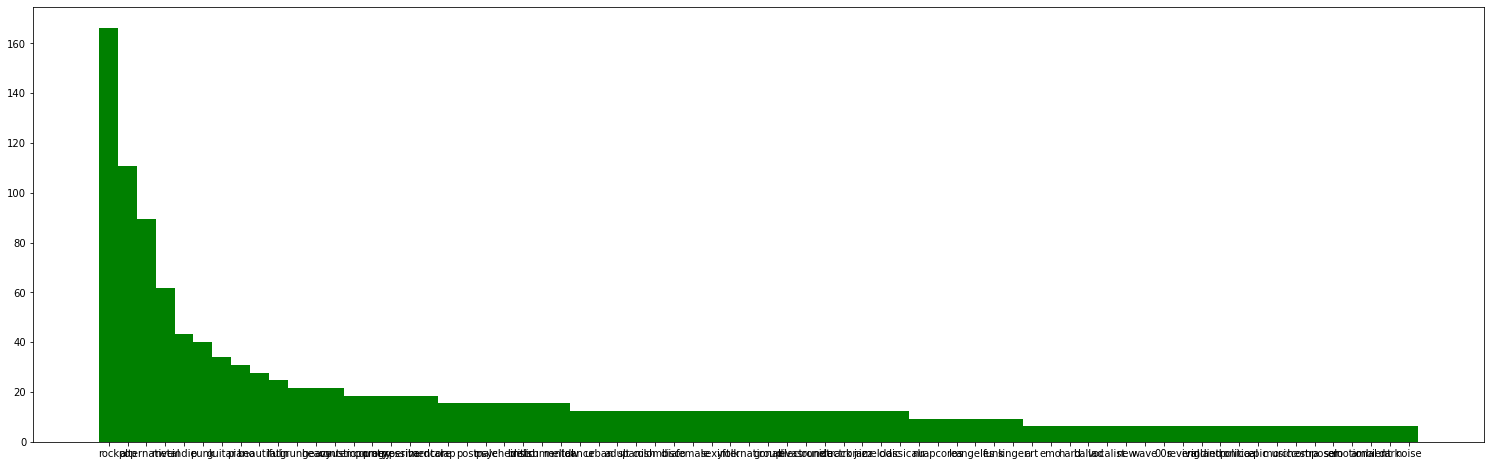

In [101]:
plt.figure(figsize = (26, 8), facecolor = None)
plt.bar(user_tfidf.keys(), user_tfidf.values(), 1, color='g')

In [116]:
def getRecommendation(user):
    user_tfidf = getTFIDFuser(user)
    first2pairs = {k: user_tfidf[k] for k in list(user_tfidf)[:7]}
    user_favourite_tags = [genre for genre, weight in first2pairs.items()]

    item_tags_for_finding_songs = []
    for items in ml_freq_pairs:
        res = len(set(user_favourite_tags) & set(items))
        uncommon_elements = set(user_favourite_tags) ^ set(items)
        if(res >= 5 ):
            item_tags_for_finding_songs.append(uncommon_elements)

    songid_matches = {}
    for index, row in songs_cleaned.iterrows():
        
        res = len(set(user_favourite_tags) & set(row['artist_terms']))
        if(res >= 6 ):
            songid_matches[row['song_id']] = res

    a = dict(sorted(songid_matches.items(), key=lambda x: x[1],  reverse=True) )
    recommendations = list(a.keys())[:10]

    return recommendations

In [119]:
user_recommendations = {}
for key in tqdm(user_profiles.keys()):
    user_recommendations[key] = getRecommendation(key)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [121]:
# Get the intra-list similarity of the model
# Average of all intra list similarities
intra_list_similar = []
for user in user_recommendations.keys():
    intra_list_similar.append(intra_list_similarity(user))
intra_similar_apriori = np.nanmean(intra_list_similar)
print("The intra list similarity for apriori model is:", intra_similar_apriori)

The intra list similarity for apriori model is: 0.5598819613191517


#### Evaluation based on similarity of recommended songs to the user profile

In [125]:
# Get the average similarity of the model
# Average of all similarities

average_similar = []
for user in user_recommendations.keys():
    average_similar.append(average_distance(user))
average_similar_apriori = np.nanmean(average_similar)
print("The average similarity for apriori model is:" , average_similar_apriori)

The average similarity for apriori model is: 4.365074349770469


# Evaluation
<a id='evaluation'></a>

In [135]:
results = pd.DataFrame({'Baseline':          [intra_similar_baseline, average_similar_baseline],
                        'Content':           [intra_similar_content, average_similar_content],
                        'Clustering':        [intra_similar_cluster, average_similar_cluster],
                        'Collaborative':     [intra_similar_collab, average_similar_collab],
                        'Collaborative KNN': [intra_similar_collab_knn, average_similar_collab_knn],
                        'Collaborative_LSH': [intra_list_similar_LSH, average_similar_LSH],
                        'Apriori':           [intra_similar_apriori, average_similar_apriori]})
results.index = ['intra list similarity', 'average similarity']
results = results.T
results.style.bar()

,intra list similarity,average similarity
Baseline,0.171185,6.224216
Content,0.516987,3.130462
Clustering,0.190452,6.084385
Collaborative,0.172952,5.047280
Collaborative KNN,0.176048,5.972385
Apriori,0.559882,4.365074


In [136]:
print(results.style.to_latex())

\begin{tabular}{lrr}
 & intra list similarity & average similarity \\
Baseline & 0.171185 & 6.224216 \\
Content & 0.516987 & 3.130462 \\
Clustering & 0.190452 & 6.084385 \\
Collaborative & 0.172952 & 5.047280 \\
Collaborative KNN & 0.176048 & 5.972385 \\
Apriori & 0.559882 & 4.365074 \\
\end{tabular}

